# Step 1: Determine what you can measure from your data

a.) Astronomical image data is usually kept in a FITS file. You will have to open that and extract the needed information first. From an image, here are some things you can likely measure: 

b.) Image Specifics: 
* exposure time
* deltaPix (pixel size in arcsec)
* numPix (number of pixels in your image)
* fwhm for the band your are working with
* Which bands will you use to model? (ex. G, R, & I bands)

c.) Lens(es) and Images:
* Number of images you can see & their respective positions
* Number of lensing galaxies & their respective positions
* I used the contour feature on the DS9 Software to measure object positions
* For now, your uncertainty is just an estimate on how well you were able to measure positions

d.) Noise: 
* background_rms can be measured by taking a portion of the image that is only noise and finding the root mean square for each band
* Small objects can be masked out during the modeling
* Larger objects may need to be subtracted using a template
* Consider other possibilities such as foreground objects, image artifacts, or an additional lensing galaxy

e.) PSF:
* A gaussian model can be used to estimate the PSF given the fwhm of each band
* A PSF model can be made from using a bright star in the near field

## a.) Get your data from a FITS file:

In [1]:
# first, we will need some imports: 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import corner  # we need this for making corner plots later
import astropy as ap
from astropy.io import fits  # you can pick your preferred fits import style
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)  # this is also my preference for making an RGB image
import pandas as pd
import math
import statistics

In [38]:
# set your filename:
filepath = '/Users/gilliancartwright/Desktop/summerproject/DES data/'  # my personal filepath
filename = filepath + 'Rob_candidates.fits'  # pre-cropped images

In [39]:
# import the data from the FITS file:
def get_data(filename):
    """
    Input: filename
    Output: data table and image array
    """
    hdu_list = fits.open(filename)  # open
    #hdu_list.info()  # show info about the file
    data = pd.DataFrame(hdu_list[2].data)  # get dataframe data
    image = hdu_list['IMAGE'].data  # get image data
    hdu_list.close()  # close
    return data, image

# show the data table: 
data, image = get_data(filename)
data.head(3)

,COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,...,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,FWHM_WMEAN_Z,SKYBRITE_WMEAN_G,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z,NAME,NAME_FOLDER
0,1400263522,DES0336-2915,2354916223,147182263,0.938449,53.898900,-28.912203,3.962615,4.879757,4.983489,...,1.09654,0.943639,0.817035,0.899360,390.652008,947.728027,3299.189941,7099.970215,DES-691022126,DES0336-2915
1,1325853948,DES0242-0041,1163420627,72713789,0.006323,40.969310,-0.619002,10.245866,10.665524,11.179090,...,1.09442,0.956736,0.894366,0.889644,459.313995,1283.849976,3451.110107,8414.360352,DES-701263907,DES0242-0041
2,1087262176,DES0038-4414,2318857161,144928572,0.545765,10.155908,-44.437518,5.865641,5.180269,5.163048,...,1.28928,1.035290,1.025070,0.777657,406.477997,1063.030029,2966.409912,8586.750000,DES-699919273,DES0038-4414


From our table, we can see there are three images, and we have information for the G, R, I, Z bands. For this example, we will only use the G, R, and I bands. We only want to work with the first image for now, so we can index the data frame using the unique COADD_OBJECT_ID:

In [40]:
coadd_id = 1400263522
row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

## b.) Get your image specific information:

This data is from DES, so we already know the following:

In [41]:
exp_time = 90.  # exposure time
deltaPix = 0.2637  # pixel size in arcsec

From our data table, we can get the fwhm for each band:

In [42]:
fwhm_g = data.iloc[row, 27]
fwhm_r = data.iloc[row, 28]
fwhm_i = data.iloc[row, 29]

We also need to know the number of pixels per axis in our image. Note: the image must be a square

In [43]:
print(image.shape)

(3, 3, 46, 46)


So the image file is organized by (number of images, number of bands, number y-axis pixels, number of x-axis pixels)

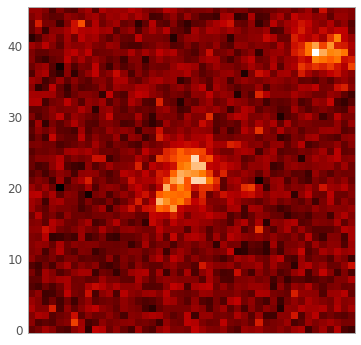

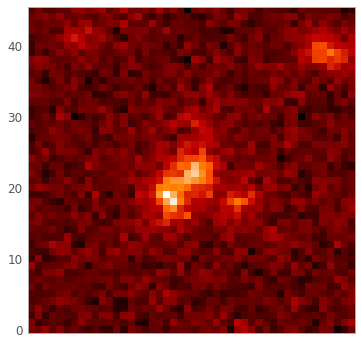

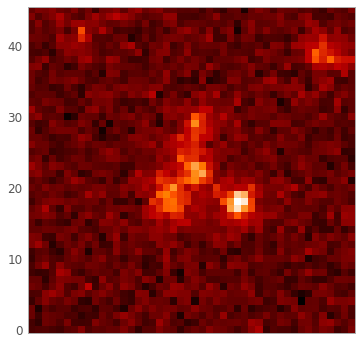

In [44]:
# set image size:
numPix = 46

# and split our image array into single bands
g = image[row, 0, :, :]  # if you need to crop your image, do it here
r = image[row, 1, :, :]  # and adjust numPix accordingly
i = image[row, 2, :, :]

# define a function to plot images
def plot_image(image_array):
    """
    Input: image array
    Output: plot of image
    """
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_xticks([])
    ax.grid(False)
    plt.show()
    plt.close()
    
# and now we can see each band:
plot_image(g)
plot_image(r)
plot_image(i)

## c.) Lens and Image positions
After looking at each band, we can start to determine which of the objects are the lens, the images, and noise. Using the DS9 contour feature, I estimated the image positions and the lens position. I also found the center of the object in the top left corner so I can mask it out later. 

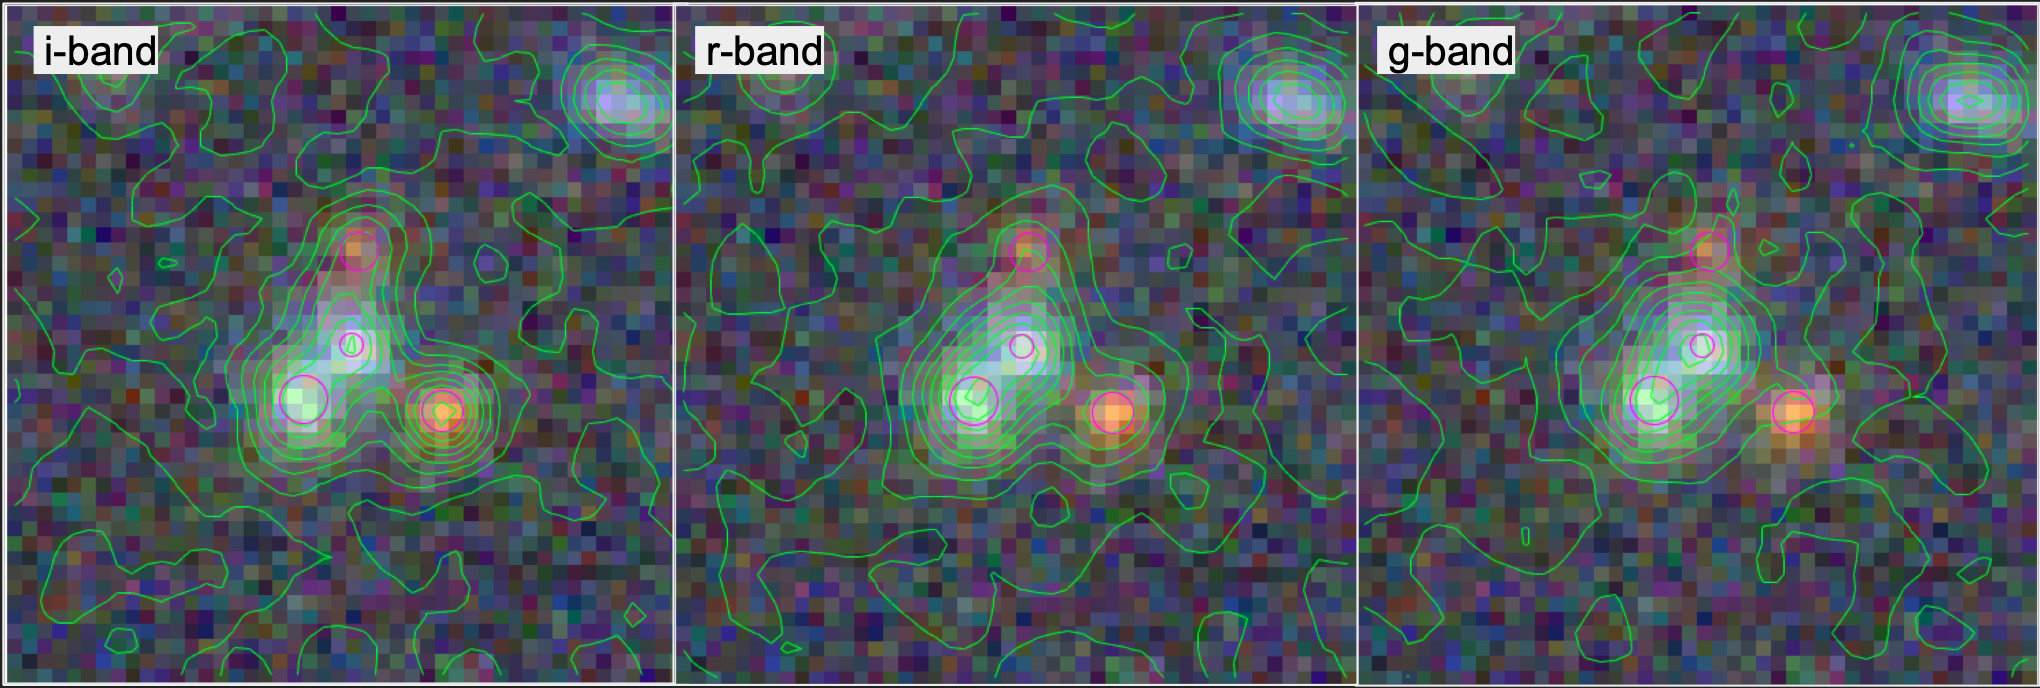

In [45]:
# image positions
x_images = [-0.618, 0.374, 1.88]
y_images = [-0.863, 1.795, -1.083]

# lens position
center_x = 0.251
center_y = 0.104

# mask positions
mask_list = [{'mask_x': 4.7, 'mask_y': 4.3, 'mask_r': 1}]

## d.) Noise
We already have an object to mask out from the previous step, but we need to get the background noise. To do this, we need to take the root mean square of all the pixels for each band.

In [46]:
# since my images were already cropped, I am importing a different, larger file for the background
rms_filename = filepath + 'Rob_candidates_larger.fits'
rms_data, rms_image = get_data(rms_filename)

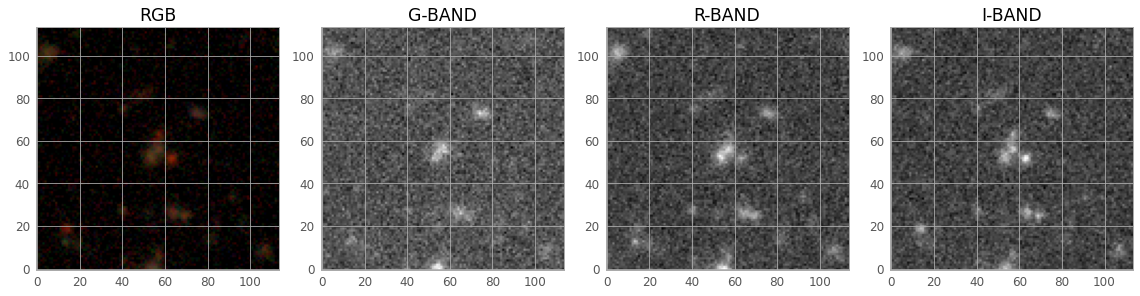

In [47]:
# another plotting function to show each band and the rgb image
def plot_all(coadd_id, image):
    """
    Input: coadd_id and image array (num_images, num_bands=3, numpix, numpix)
    Output: RGB image, and G, R, I plots for single image (indexed by coadd_id)
    """
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))

    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :] # get image array
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    ax[0].imshow(rgb_image, origin='lower')  # RGB
    ax[0].set_title('RGB')

    ax[1].imshow(image[row, 0, :, :], cmap='gray', origin='lower')  # g-band
    ax[1].set_title('G-BAND')

    ax[2].imshow(image[row, 1, :, :], cmap='gray', origin='lower')  # r-band
    ax[2].set_title('R-BAND')

    ax[3].imshow(image[row, 2, :, :], cmap='gray', origin='lower')  # i-band
    ax[3].set_title('I-BAND')

    plt.tight_layout()
    plt.show()
    plt.close()
    
plot_all(coadd_id, rms_image)

In [48]:
# We need an empty section of the image
crop = [[85, 114], [85, 114]]

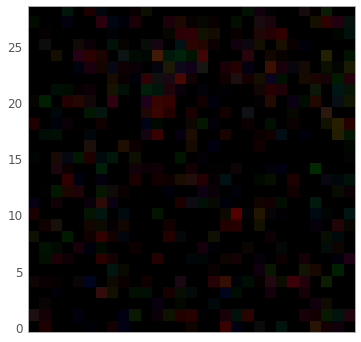

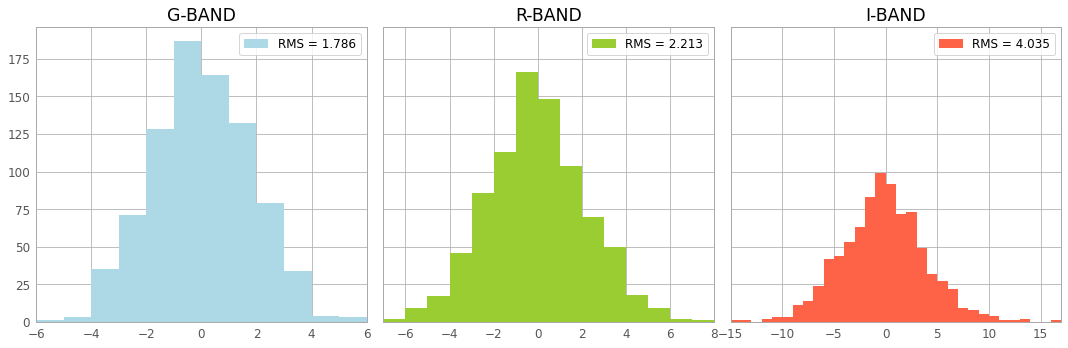

In [49]:
# now we can define functions to get the rms of the cropped region:
def get_stats(flat_image):
    """
    Input: 1d numpy array of image (flattened image)
           note: to flatten an image use '1d_array = 2d_array.flatten()'
    Output: number of bins for histogram based on spread of data,
            integer values of min and max (used for range of x-axis)
            root mean square value
    """
    min_int = math.floor(np.amin(flat_image))  # round min down to int
    max_int = math.ceil(np.amax(flat_image))  # round max up to int
    Bins = abs(min_int)+max_int  # num bins = one per integer value
    rms = np.sqrt(np.mean(flat_image**2))  # calculate rms
    return Bins, min_int, max_int, rms

def get_rms(filename, coadd_id, crop):
    """
    Long Version:
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: RGB image of region to check that selected region is good,
            histogram for each band, returns rms_list (g,r,i)
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    rgb_crop = ap.visualization.make_lupton_rgb(i_crop, r_crop,
                                                g_crop, stretch=50, Q=10)
    plot_image(rgb_crop)  # check rgb image

    g_flat = g_crop.flatten()  # make 2d image array into 1d np array
    r_flat = r_crop.flatten()
    i_flat = i_crop.flatten()

    rms_list = []  # each rms value will be saved here and returned

    # set up figure and axes for plotting
    f, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # settings for each band (flattened image, index, plot title and color)
    band_flats = [g_flat, r_flat, i_flat]  # combine flattened images into list
    band_index = range(len(band_flats))  # make list of band indices
    band_names = ['G-BAND', 'R-BAND', 'I-BAND']  # set band labels
    band_colors = ['lightblue', 'yellowgreen', 'tomato']  # set plot colors
    combined_lists = zip(band_flats, band_index, band_names, band_colors)

    # loop to set ax for each band
    for flat_image, index, name, color in combined_lists:
        Bins, min_int, max_int, rms = get_stats(flat_image)  # get stats
        rms_list.append(rms)  # save rms

        # create ax for g,r,i bands
        ax[index].hist(flat_image, bins=Bins, range=(min_int, max_int),
                       color=color, label='RMS = '+str(round(rms, 3)))
        ax[index].set_title(name)  # show title
        ax[index].set_xlim(xmin=min_int, xmax=max_int)
        ax[index].legend()  # show rms in legend rounded to 3 decimals

    plt.tight_layout()
    plt.show()
    plt.close()
    return rms_list


rms_list = get_rms(rms_filename, coadd_id, crop)  # save in rms_list


## e.) PSF:

To keep things simple, we will use a gaussian estimate of the PSF that is calculated from the fwhm of the band. We already have the fwhm so all we have to do is set the psf_type:

In [50]:
psf_type = 'GAUSSIAN'  # 'PIXEL' for other model

Done! We have all the data we need for now, so the next step is creating a simulation. See the next notebook Step 2, Simulating Data